# Pose Detection Using Movenet

## What Does This Notebook Do?
This notebook uses [Movenet model from TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/movenet).

## Pre-requisites
* Download [lightning](https://tfhub.dev/google/movenet/singlepose/lightning/4) version of the movenet model from the TF hub.
* Good to enable GPU as the inference is a little faster on it.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import time
    
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

tf.config.list_physical_devices()
# tf.debugging.set_log_device_placement(True)
# tf.config.set_visible_devices([], 'GPU')

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")


2022-10-20 16:22:54.985691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU foundMetal device set to: AMD Radeon Pro 5300M



2022-10-20 16:22:59.217812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 16:22:59.218461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 16:22:59.218502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 16:22:59.218667: I tensorflow/core/

In [2]:
# def test_gpu_with_cifar():
#     cifar = tf.keras.datasets.cifar100
#     (x_train, y_train), (x_test, y_test) = cifar.load_data()
#     model = tf.keras.applications.ResNet50(
#         include_top=True,
#         weights=None,
#         input_shape=(32, 32, 3),
#         classes=100,)

#     loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#     model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
#     model.fit(x_train, y_train, epochs=5, batch_size=64)

In [3]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
    """Returns high confidence keypoints and edges for visualization.

    Args:
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
          the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
        keypoint_threshold: minimum confidence score for a keypoint to be
        visualized.

    Returns:
        A (keypoints_xy, edges_xy, edge_colors) containing:
          * the coordinates of all keypoints of all detected entities;
          * the coordinates of all skeleton edges of all detected entities;
          * the colors in which the edges should be plotted.
    """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
            [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
        kpts_above_thresh_absolute = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (kpts_scores[edge_pair[0]] > keypoint_threshold and
              kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
    """Draws the keypoint predictions on image.

        Args:
        image: A numpy array with shape [height, width, channel] representing the
          pixel values of the input image.
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
          the keypoint coordinates and scores returned from the MoveNet model.
        crop_region: A dictionary that defines the coordinates of the bounding box
          of the crop region in normalized coordinates (see the init_crop_region
          function below for more detail). If provided, this function will also
          draw the bounding box on the image.
        output_image_height: An integer indicating the height of the output image.
          Note that the image aspect ratio will be the same as the input image.

      Returns:
        A numpy array with shape [out_height, out_width, channel] representing the
        image overlaid with keypoint predictions.
      """
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle='solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    (keypoint_locs, keypoint_edges,
       edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize=(output_image_width, output_image_height),
             interpolation=cv2.INTER_CUBIC)
    return image_from_plot

def to_gif(images, fps):
    """Converts image sequence (4D numpy array) to gif."""
    imageio.mimsave('./animation.gif', images, fps=fps)
    return embed.embed_file('./animation.gif')

def progress(value, max=100):
    return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
    """.format(value=value, max=max))

In [4]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
    """Defines the default crop region.

    The function provides the initial crop region (pads the full image from both
    sides to make it a square image) when the algorithm cannot reliably determine
    the crop region from the previous frame.
    """
    if image_width > image_height:
        box_height = image_width / image_height
        box_width = 1.0
        y_min = (image_height / 2 - image_width / 2) / image_height
        x_min = 0.0
    else:
        box_height = 1.0
        box_width = image_height / image_width
        y_min = 0.0
        x_min = (image_width / 2 - image_height / 2) / image_width

    return {
      'y_min': y_min,
      'x_min': x_min,
      'y_max': y_min + box_height,
      'x_max': x_min + box_width,
      'height': box_height,
      'width': box_width
    }

def torso_visible(keypoints):
    """Checks whether there are enough torso keypoints.

    This function checks whether the model is confident at predicting one of the
    shoulders/hips which is required to determine a good crop region.
    """
    return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
             MIN_CROP_KEYPOINT_SCORE or
            keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
             MIN_CROP_KEYPOINT_SCORE) and
            (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
             MIN_CROP_KEYPOINT_SCORE or
            keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
             MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
    """Calculates the maximum distance from each keypoints to the center location.

    The function returns the maximum distances from the two sets of keypoints:
    full 17 keypoints and 4 torso keypoints. The returned information will be
    used to determine the crop size. See determineCropRegion for more detail.
    """
    torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    max_torso_yrange = 0.0
    max_torso_xrange = 0.0
    for joint in torso_joints:
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_torso_yrange:
            max_torso_yrange = dist_y
        if dist_x > max_torso_xrange:
            max_torso_xrange = dist_x

    max_body_yrange = 0.0
    max_body_xrange = 0.0
    for joint in KEYPOINT_DICT.keys():
        if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
            continue
        dist_y = abs(center_y - target_keypoints[joint][0]);
        dist_x = abs(center_x - target_keypoints[joint][1]);
        if dist_y > max_body_yrange:
            max_body_yrange = dist_y

        if dist_x > max_body_xrange:
            max_body_xrange = dist_x

    return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
    """Determines the region to crop the image for the model to run inference on.

    The algorithm uses the detected joints from the previous frame to estimate
    the square region that encloses the full body of the target person and
    centers at the midpoint of two hip joints. The crop size is determined by
    the distances between each joints and the center point.
    When the model is not confident with the four torso joint predictions, the
    function returns a default crop which is the full image padded to square.
    """
    target_keypoints = {}
    for joint in KEYPOINT_DICT.keys():
        target_keypoints[joint] = [
            keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
            keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
        ]

    if torso_visible(keypoints):
        center_y = (target_keypoints['left_hip'][0] +
                      target_keypoints['right_hip'][0]) / 2;
        center_x = (target_keypoints['left_hip'][1] +
                      target_keypoints['right_hip'][1]) / 2;

        (max_torso_yrange, max_torso_xrange,
            max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
                keypoints, target_keypoints, center_y, center_x)

        crop_length_half = np.amax(
              [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
                max_body_yrange * 1.2, max_body_xrange * 1.2])

        tmp = np.array(
              [center_x, image_width - center_x, center_y, image_height - center_y])
        crop_length_half = np.amin(
              [crop_length_half, np.amax(tmp)]);

        crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

        if crop_length_half > max(image_width, image_height) / 2:
            return init_crop_region(image_height, image_width)
        else:
            crop_length = crop_length_half * 2;
            # return {
            #   'y_min': crop_corner[0] / image_height,
            #   'x_min': crop_corner[1] / image_width,
            #   'y_max': (crop_corner[0] + crop_length) / image_height,
            #   'x_max': (crop_corner[1] + crop_length) / image_width,
            #   'height': (crop_corner[0] + crop_length) / image_height -
            #       crop_corner[0] / image_height,
            #   'width': (crop_corner[1] + crop_length) / image_width -
            #       crop_corner[1] / image_width
            # }
            return {
              'y_min': crop_corner[0],
              'x_min': crop_corner[1],
              'y_max': (crop_corner[0] + crop_length),
              'x_max': (crop_corner[1] + crop_length),
              'height': crop_length,
              'width': crop_length
            }
    else:
          return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
    """Crops and resize the image to prepare for the model input."""
    boxes=[[crop_region['y_min'], crop_region['x_min'],
            crop_region['y_max'], crop_region['x_max']]]
    output_image = tf.image.crop_and_resize(
        image, box_indices=[0], boxes=boxes, crop_size=crop_size)
    return output_image

def run_inference(movenet, image, crop_region, crop_size):
    """Runs model inferece on the cropped region.

    The function runs the model inference on the cropped region and updates the
    model output to the original image coordinate system.
    """
    image_height, image_width, _ = image.shape
    input_image = crop_and_resize(
      tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    # Update the coordinates.
    for idx in range(17):
        keypoints_with_scores[0, 0, idx, 0] = (
              crop_region['y_min'] * image_height +
              crop_region['height'] * image_height *
              keypoints_with_scores[0, 0, idx, 0]) / image_height
        keypoints_with_scores[0, 0, idx, 1] = (
              crop_region['x_min'] * image_width +
              crop_region['width'] * image_width *
              keypoints_with_scores[0, 0, idx, 1]) / image_width
    return keypoints_with_scores

In [5]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

# Lightning
if "movenet_lightning" in model_name:
    input_size = 192
    model_file = 'movenet_singlepose_lightning_4'        
elif "movenet_thunder" in model_name:
    model_file = 'movenet_singlepose_thunder_4'
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = tf.saved_model.load(model_file)
    infer = model.signatures["serving_default"]

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = infer(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [6]:
def get_bounding_box(keypoints_with_scores, height, width, input_size, keypoint_threshold=0.0):
    kpts_x = keypoints_with_scores[0, 0, :, 1]
    kpts_y = keypoints_with_scores[0, 0, :, 0]
    kpts_scores = keypoints_with_scores[0, 0, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[kpts_scores > keypoint_threshold, :]
    kpts_x = kpts_above_thresh_absolute[:, 1]
    kpts_y = kpts_above_thresh_absolute[:, 0]
    x_min = kpts_x.min() - 10 
    y_min = kpts_y.min() - 10
    x_max = kpts_x.max() + 10
    y_max = kpts_y.max() + 10

    return {
      'y_min': y_min,
      'x_min': x_min,
      'y_max': y_max,
      'x_max': x_max,
      'height': y_max - y_min,
      'width': x_max - x_min
    }
    

def plot_bounding_box(crop_region):
    y_min = crop_region['y_min']
    x_min = crop_region['x_min']
    y_max = crop_region['y_max']
    x_max = crop_region['x_max']
    height = crop_region['height']
    width = crop_region['width']
    print(f'crop_region:{crop_region}')
    ax = plt.gca()
    
    ax.add_patch(patches.Rectangle((y_min, x_min), height, width, linewidth=1, edgecolor='r', facecolor='none'))
    # ax.add_patch(patches.Rectangle((10, 10), 200, 200, linewidth=1, edgecolor='r', facecolor='none'))

    
def inference(image_path):
    start = time.time()
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image_height, image_width, _ = image.shape
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    # print(f'keypoints_with_scores: {keypoints_with_scores}')
    
    # Get ideal crop region.
    # crop_region = get_bounding_box(
      # keypoints_with_scores, image_height, image_width, input_size)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(output_overlay)
    _ = plt.axis('off')
    # plot_bounding_box(crop_region)
    plt.show()
    end = time.time()
    print(f'Time taken: {end - start}')
    

2022-10-20 16:22:59.948887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 16:22:59.948931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-20 16:23:11.859826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


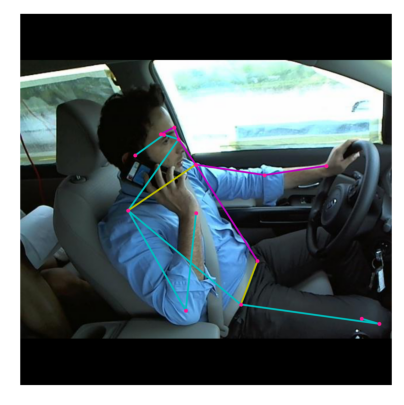

Time taken: 17.060011863708496


In [7]:
# inference('input_image.jpeg')
inference('img_13.jpg')
# inference('img_24.jpg')
# inference('img_28.jpg')
# inference('img_36.jpg')
